Simple Segmentation Net

In [7]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os

import SimpleITK as sitk

from Dataset_Utils import BraTS_TrainingDataset
from Dataset_Utils import plot_batch, crop_batch, decrop_batch, split_cube

torch.manual_seed(42)

Data Loading

In [8]:
Scans = {
    0: 'FLAIR',
    1: 'T1w',
    2: 't1gd',
    3: 'T2w'}

Labels = {
    0: 'background',
    1: 'edema',
    2: 'non-enhancing tumor',
    3: 'enhancing tumour'}

In [9]:
# PATH
dataset_path = '/media/linux/Extreme SSD/brainTumourProject/Task01_BrainTumour/cropped/'

train_data = BraTS_TrainingDataset(dataset_path)

trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=1, shuffle=True, num_workers=0)

train_iter = iter(trainloader)

sample_batch = train_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)

# plot_batch(sample_batch, num_rows=2, height=75)

/media/linux/Extreme SSD/brainTumourProject/Task01_BrainTumour/cropped/imagesTr
/media/linux/Extreme SSD/brainTumourProject/Task01_BrainTumour/cropped/labelsTr
torch.Size([1, 4, 155, 192, 192])
torch.Size([1, 155, 192, 192])


Create the model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cpu


In [21]:
# Armin's alternative centercrop function (needs some editing in the return statement)
def center_cropping(z,x,y,img):
    to_crop_z = img.shape[1] - z
    to_crop_x = img.shape[2] - x
    to_crop_y = img.shape[3] - y
    get_bound = lambda x,length: (x/2,(length-2/2)+ 1) if x%2 == 0 else (x//2 + 1, length-x//2)
    slice_z = get_bound(to_crop_z,img.shape[1])
    slice_x = get_bound(to_crop_x,img.shape[2])
    slice_y = get_bound(to_crop_y,img.shape[3])
    return img[:,slice_z(0):slice_z(1),slice_x(0):slice_x(1),slice_y(0):slice_y(1)] 

In [12]:
class SmallBTSegNet(nn.Module):

    def downward_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        """
        The downward blocks are part of the contracting path.
        Utility:
        - decrease the depth, height and width.
        - increase the number of channels.
        The result is that features get more high level
        and spatial information decreases with each downward block.
        """
        downward_block = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            # nn.BatchNorm3d(out_channels),
                
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            # nn.BatchNorm3d(out_channels),
            )
        return downward_block
    
    def upward_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        """
        The upward blocks are part of the expanding path.
        Utility:
        - increase the number of depth, height and width.
        - decrease the number of channels.
        The result is a segmentation map that increases
        in resolution for each upward block.
        """
        mid_channels = in_channels//2
        # E.g.: in_c = 512, mid_c = 256, out_c = 128
        
        upward_block = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=mid_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            # nn.BatchNorm3d(mid_channels),
                
            nn.Conv3d(in_channels=mid_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            # nn.BatchNorm3d(out_channels))
        )
        
        return upward_block
    
    def __init__(self, num_modalities, num_classes, img_height, img_width):
        
        self.DEBUG = True
        
        super(SmallBTSegNet, self).__init__()
        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # downward layers
        self.down1 = self.downward_block(in_channels=num_modalities, out_channels=64, 
                                      kernel_size=3, stride=1, padding=0)
    
        self.down2 = self.downward_block(in_channels=64, out_channels=128, 
                                      kernel_size=3, stride=1, padding=0)
        
        self.down3 = self.downward_block(in_channels=128, out_channels=256, 
                                      kernel_size=3, stride=1, padding=0)
        
        self.down4 = self.downward_block(in_channels=256, out_channels=512, 
                                      kernel_size=3, stride=1, padding=0)
            
        #self.same_conv = nn.Sequential(
        #    nn.Conv3d(in_channels=32, out_channels=32,
        #              kernel_size=3, stride=1, padding=1),
        #    nn.ReLU(),
        #    nn.BatchNorm3d(32),
        #)
        
        self.upconv1 = nn.ConvTranspose3d(in_channels=512, out_channels=256,
                              kernel_size=2, stride=2, padding=0, output_padding=1)
        
        self.up1 = self.upward_block(in_channels=512, out_channels=256, 
                                     kernel_size=3, stride=1, padding=0)
        
        self.upconv2 = nn.ConvTranspose3d(in_channels=256, out_channels=128,
                              kernel_size=2, stride=2, padding=0, output_padding=1)
        
        self.up2 = self.upward_block(in_channels=256, out_channels=128, 
                                     kernel_size=3, stride=1, padding=0)
        
        self.upconv3 = nn.ConvTranspose3d(in_channels=128, out_channels=64,
                              kernel_size=2, stride=2, padding=0, output_padding=1)
        
        self.up3 = self.upward_block(in_channels=128, out_channels=64, 
                                     kernel_size=3, stride=1, padding=0)
            
        self.out_conv = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=4,
                      kernel_size=3, stride=1, padding=0),
            # nn.ReLU(),
        )
        
    def forward(self, x):
        x = torch.FloatTensor(x).to(device)
        
        # downward layers
        x = self.down1(x)
        l1_out = torch.clone(x)
        l1_transform = transforms.CenterCrop((55)) # CenterCrop transform only handles 2D
        l1_out_crop = l1_transform(torch.clone(x)) # Apply transform
        l1_out_crop = l1_out_crop[:,58:93,:,:] # Take care of 3rd dim. separately
        x = self.maxpool(x)
        
        x = self.down2(x)
        l2_transform = transforms.CenterCrop((59))
        l2_out_crop = l2_transform(torch.clone(x))
        l2_out_crop = l2_out_crop[:,16:55,:,:]
        l2_out = torch.clone(x)
        x = self.maxpool(x)
        
        x = self.down3(x)
        l3_transform = transforms.CenterCrop((33))
        l3_out_crop = l3_transform(torch.clone(x))
        l3_out_crop = l3_out_crop[:,4:27,:,:]
        l3_out = torch.clone(x)
        x = self.maxpool(x)
            
        x = self.down4(x)
        l4_out = torch.clone(x)
        # x = self.maxpool(x)
        
        # bottom floor
        # x = self.same_conv(x)
        # x = self.same_conv(x)
        
        if self.DEBUG:
            print('l1_out:', l1_out.shape)
            print('l1_out_crop:', l1_out_crop.shape)
            print('l2_out:', l2_out.shape)
            print('l2_out_crop:', l2_out_crop.shape)
            print('l3_out:', l3_out.shape)
            print('l3_out_crop:', l3_out_crop.shape)
            print('l4_out:', l4_out.shape)
            print('x:', x.shape)
        
        # upward layers
        x = self.upconv1(x)
        if self.DEBUG:
            print('after upconv1:', x.shape)
        x = torch.cat((l3_out_crop, x), dim=0)
        if self.DEBUG:
            print('after cat:', x.shape)
        x = self.up1(x)
        if self.DEBUG:
            print('after up1:', x.shape)
        
        x = self.upconv2(x)
        if self.DEBUG:
            print('after upconv2:', x.shape)
        x = torch.cat((l2_out_crop, x), dim=0)
        if self.DEBUG:
            print('after cat:', x.shape)
        x = self.up2(x)
        if self.DEBUG:
            print('after up2:', x.shape)
        
        x = self.upconv3(x)
        if self.DEBUG:
            print('after upconv3:', x.shape)
        x = torch.cat((l1_out_crop, x), dim=0)
        if self.DEBUG:
            print('after cat:', x.shape)
        x = self.up3(x)
        if self.DEBUG:
            print('after up3:', x.shape)
        
        # output conv block
        x = self.out_conv(x)
        if self.DEBUG:
            print('after out conv:', x.shape)       
        return x
    
# summary
# print(SmallBTSegNet(num_modalities=4, num_classes=4, img_height=96, img_width=96))

# init model
# model = SmallBTSegNet(num_modalities=4, num_classes=4, img_height=96, img_width=96).to(device)
model = SmallBTSegNet(num_modalities=4, num_classes=4, img_height=192, img_width=192).to(device)

Test & debug model

In [13]:
# Sample a minicube batch
# minicube_batch = split_cube(train_iter.next())

In [14]:
# voxel_logits_batch = model.forward(minicube_batch['image'][:1,:,:,:,:])

In [9]:
# test on a sample image (WHOLE)
dat = np.load("0.npy")

fdat = model.forward(dat)

Training loop utils

In [15]:
# test alternative centercrop on a sample tensor
Z = torch.zeros(4, 155, 192, 192)
Z.shape

In [22]:
## errors to be fixed
out = center_cropping(100,100,100,Z)
print(out.shape)

TypeError: 'tuple' object is not callable

In [ ]:
# test forward path on zeros
# zdat = model.forward(Z)

l1_out: torch.Size([64, 151, 188, 188])
l1_out_crop: torch.Size([64, 35, 55, 55])
l2_out: torch.Size([128, 71, 90, 90])
l2_out_crop: torch.Size([128, 39, 59, 59])
l3_out: torch.Size([256, 31, 41, 41])
l3_out_crop: torch.Size([256, 23, 33, 33])
l4_out: torch.Size([512, 11, 16, 16])
x: torch.Size([512, 11, 16, 16])
after upconv1: torch.Size([256, 23, 33, 33])
after cat: torch.Size([512, 23, 33, 33])


In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
def get_minicube_batch_loss(minicube_batch, step, device):
    if step%4 == 0:
        voxel_logits_batch = model.forward(minicube_batch['image'][:2,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][:2,:,:,:].long().to(device))
        return loss
    
    elif step%4 == 1:
        voxel_logits_batch = model.forward(minicube_batch['image'][2:4,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][2:4,:,:,:].long().to(device))
        return loss
    
    elif step%4 == 2:
        voxel_logits_batch = model.forward(minicube_batch['image'][4:6,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][4:6,:,:,:].long().to(device))
        return loss
    
    else:
        voxel_logits_batch = model.forward(minicube_batch['image'][6:,:,:,:,:])
        loss = criterion(voxel_logits_batch, minicube_batch['label'][6:,:,:,:].long().to(device))
        return loss

Training Loop

In [11]:
# define optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

# training settings
epochs = 4
steps_per_epoch = 400
losses = []

# training loop
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        
        if step%8 == 0:
            # Get a new minicube batch
            minicube_batch = split_cube(train_iter.next())
        
        loss = get_minicube_batch_loss(minicube_batch, step, device=device)
        losses.append(loss)
        
        if step%20 == 0:
            print(f'epoch {epoch}: step {step:3d}: loss={loss:3.3f}')
            path = f'../Weights/weights_epoch{epoch}_step{step}_loss{loss:3.3f}.h5'
            torch.save(model.state_dict(), path)
        
        # backprop loss
        optim.zero_grad()
        loss.backward()
        optim.step()

epoch 0: step   0: loss=1.407
epoch 0: step  20: loss=0.843
epoch 0: step  40: loss=0.590
epoch 0: step  60: loss=0.507
epoch 0: step  80: loss=0.456
epoch 0: step 100: loss=0.418
epoch 0: step 120: loss=0.424
epoch 0: step 140: loss=0.283
epoch 0: step 160: loss=0.260
epoch 0: step 180: loss=0.327
epoch 0: step 200: loss=0.226
epoch 0: step 220: loss=0.162
epoch 0: step 240: loss=0.158
epoch 0: step 260: loss=0.113
epoch 0: step 280: loss=0.121
epoch 0: step 300: loss=0.081
epoch 0: step 320: loss=0.072
epoch 0: step 340: loss=0.145
epoch 0: step 360: loss=0.077
epoch 0: step 380: loss=0.086
epoch 1: step   0: loss=0.080
epoch 1: step  20: loss=0.103
epoch 1: step  40: loss=0.090
epoch 1: step  60: loss=0.085
epoch 1: step  80: loss=0.066
epoch 1: step 100: loss=0.048
epoch 1: step 120: loss=0.070
epoch 1: step 140: loss=0.050
epoch 1: step 160: loss=0.086
epoch 1: step 180: loss=0.053
epoch 1: step 200: loss=0.062
epoch 1: step 220: loss=0.049
epoch 1: step 240: loss=0.050
epoch 1: s

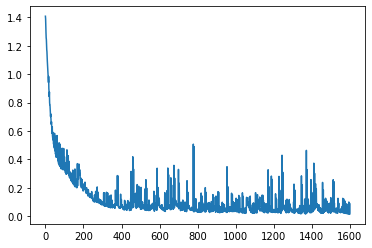

In [80]:
losses_array = [l.detach().cpu().numpy() for l in losses]
np.savetxt('losses.csv', losses_array, delimiter=',', fmt='%f')
plt.plot(losses_array)
savefig('losses.png', bbox_inches='tight')

In [81]:
# load weights
weights_filename = 'weights_epoch3_step300_loss0.026.h5'
inference_model = SmallBTSegNet(num_modalities=4, num_classes=4, img_height=96, img_width=96).to(device)
inference_model.load_state_dict(torch.load('../Weights/' + weights_filename))
inference_model.eval()

SmallBTSegNet(
  (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Sequential(
    (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down2): Sequential(
    (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down3): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 

Predict

In [109]:
# predict batch
voxel_logits_batch = inference_model.forward(minicube_batch['image'][None,4,:,:,:,:])

# get loss
loss = criterion(voxel_logits_batch, minicube_batch['label'][None,4,:,:,:].long().to(device))
print(f'loss: {loss.item():3.3f}')

sm = nn.Softmax(dim=1)
voxel_probs_batch = sm(voxel_logits_batch)
print(voxel_probs_batch.shape)

probs, out = torch.max(voxel_probs_batch, dim=1)

loss: 0.175
torch.Size([1, 4, 80, 96, 96])


prediction:


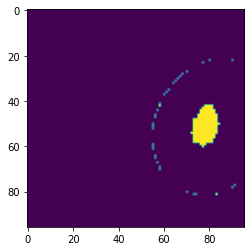

In [99]:
print('prediction:')
plt.imshow(out[0, 5, :,:].cpu())
savefig('prediction1.png', bbox_inches='tight')

label:


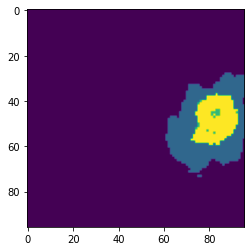

In [100]:
print('label:')
plt.imshow(minicube_batch['label'][4, 5, :, :].cpu())
savefig('prediction2.png', bbox_inches='tight')